In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [2]:
# move into project directory
repo_name = "Image-Colorization"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/Image-Colorization
common	     dataloading  Index.ipynb  output		     README.md	       transforms
config.yaml  experiments  index.py     preprocess	     requirements.txt  visualization
data	     Index_bc.py  models       project-structure.md  run.yaml


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

'\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118\n!pip install matplotlib numpy pandas pyyaml opencv-python\n'

In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder


In [5]:
# setup some imports
#custom imports
from transforms.transforms import ToTensor
from dataloading.datareader import DataReader
from dataloading.dataset import CustomDataset
from common.utils import get_exp_params, init_config, get_config, save2config, get_saved_model, get_modelinfo, get_model_data
from models.unet import UNet
from models.custom_models import get_model

#py imports
import random
import numpy as np
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from experiments.experiments import Experiment
from visualization.visualization import Visualization
from experiments.test_model import ModelTester

In [6]:
# initialize directories and config data
init_config()
config = get_config()
print('Config parameters\n')
print(config)

Config parameters

{'X_key': 'L', 'data_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/Image-Colorization', 'use_gpu': True, 'y_key': 'AB'}


In [7]:
# read experiment parameters
exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 256, 'crop_dim': 224}, 'train': {'shuffle_data': True, 'batch_size': 128, 'val_split_method': 'fixed-split', 'k': 3, 'val_percentage': 20, 'loss': 'mse', 'batch_interval': 512, 'epoch_interval': 100, 'num_epochs': 5000}, 'model': {'name': 'unet', 'optimizer': 'Adam', 'lr': 8e-05, 'weight_decay': 1e-07, 'amsgrad': True, 'momentum': 0.85}, 'test_model': False}


In [8]:
#initialize randomness seed
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [9]:
#save X_key and y_key
save2config('X_key', 'L')
save2config('y_key', 'AB')

#preprocess data or load preprocessed data
dr = DataReader()
ds = dr.get_split_data()
Ltr, ABtr, ftr_len = ds['Ltr'], ds['ABtr'], ds['ftr_len']
Lte, ABte, te_len = ds['Lte'], ds['ABte'], ds['te_len']
print('Shape of X and y:', ds['Ltr'].shape, ds['ABtr'].shape)

#transform data
composed_transforms =  transforms.Compose([
    ToTensor()
])
#convert to dataset
ftr_dataset = CustomDataset(Ltr, ABtr, ftr_len)
te_dataset = CustomDataset(Lte, ABte, te_len)
smlen = int(0.01 * len(ftr_dataset))
smftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(smlen)))
smftrte_dataset = torch.utils.data.Subset(ftr_dataset, list(range(10)))
smtelen = int(0.1 * len(te_dataset))
smfte_dataset = torch.utils.data.Subset(te_dataset, list(range(smtelen)))
print('Full train dataset length:', len(ftr_dataset))
print('Test dataset length:', len(te_dataset))
print('Subset train dataset length:', smlen)
print('Subset test dataset length:', smtelen, '\n')


Shape of X and y: (50000, 1, 32, 32) (50000, 2, 32, 32)
Full train dataset length: 50000
Test dataset length: 10
Subset train dataset length: 500
Subset test dataset length: 1 



In [10]:
'''
#model training with small dataset
exp = Experiment(exp_params["model"]["name"], smftr_dataset)
model_history = exp.train()
'''

'\n#model training with small dataset\nexp = Experiment(exp_params["model"]["name"], smftr_dataset)\nmodel_history = exp.train()\n'

In [11]:
'''
# get best model with small dataset
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')
print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()
'''

'\n# get best model with small dataset\nmodel, model_history, _ = get_model_data(exp_params["model"]["name"])\n#model = get_saved_model(model, \'\')\nmodel_info = get_modelinfo(\'\')\nprint("\nModel validation results")\n#visualization results\nvis = Visualization(model_info, model_history)\nvis.get_results()\n'

In [12]:
#model training with full dataset

exp = Experiment(exp_params["model"]["name"], ftr_dataset)
model_history = exp.train()

Running straight split
Loading saved model
	Running Epoch 4800


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 63.76it/s]


	Epoch 4800 Training Loss: 0.008609330900013448
	Epoch 4800 Validation Loss: 0.01644998558759689
	Epoch 4800 Validation Accuracy: 0.0

	Running Epoch 4900


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 63.37it/s]


	Epoch 4900 Training Loss: 0.008579062964022159
	Epoch 4900 Validation Loss: 0.016066081120073794
	Epoch 4900 Validation Accuracy: 0.0

	Running Epoch 5000


		Running through validation set: 100%|██████████| 79/79 [00:01<00:00, 56.56it/s]


	Epoch 5000 Training Loss: 0.008627535647153855
	Epoch 5000 Validation Loss: 0.015718762281537055
	Epoch 5000 Validation Accuracy: 0.0




Model validation results

Model results




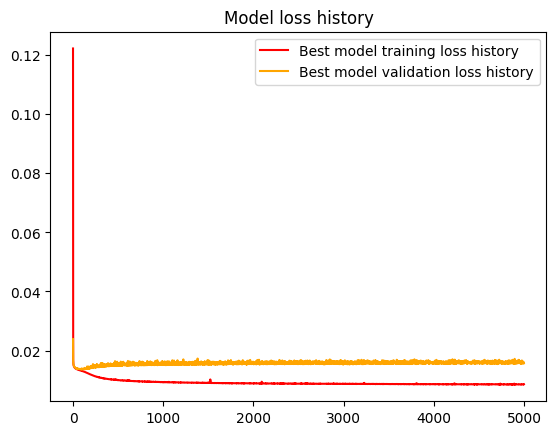

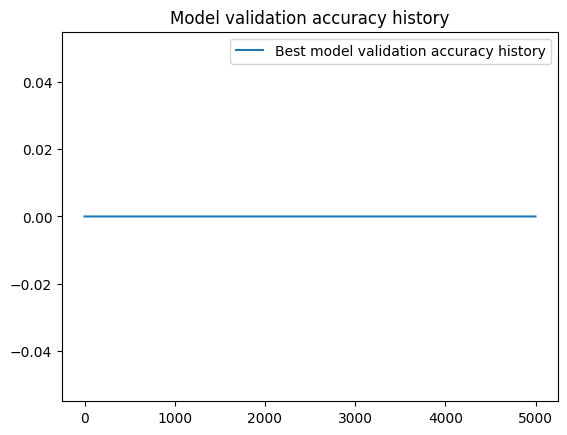


Model Training Loss: 0.008627535647153855
Model Validation Loss: 0.015718762281537055
Model Accuracy: 0.0



In [13]:
# get best model
model, model_history, _ = get_model_data(exp_params["model"]["name"])
#model = get_saved_model(model, '')
model_info = get_modelinfo('')

print("\nModel validation results")
#visualization results
vis = Visualization(model_info, model_history)
vis.get_results()



Testing Saved Model


<Figure size 640x480 with 0 Axes>

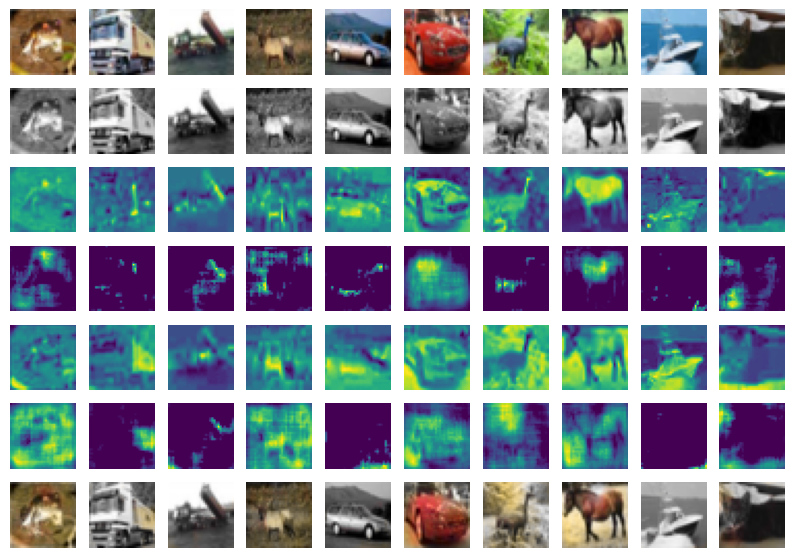


Test Loss: 0.01419328898191452
Test Accuracy: tensor(0.1000) 



In [14]:
#model testing with small subset of training dataset
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smftrte_dataset)
mt.test_and_plot(ds["RGBtr"], ABtr, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

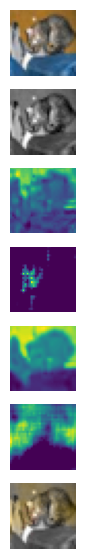


Test Loss: 0.019893180578947067
Test Accuracy: tensor(0.) 



In [15]:
#model testing with small test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, smfte_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)



Testing Saved Model


<Figure size 640x480 with 0 Axes>

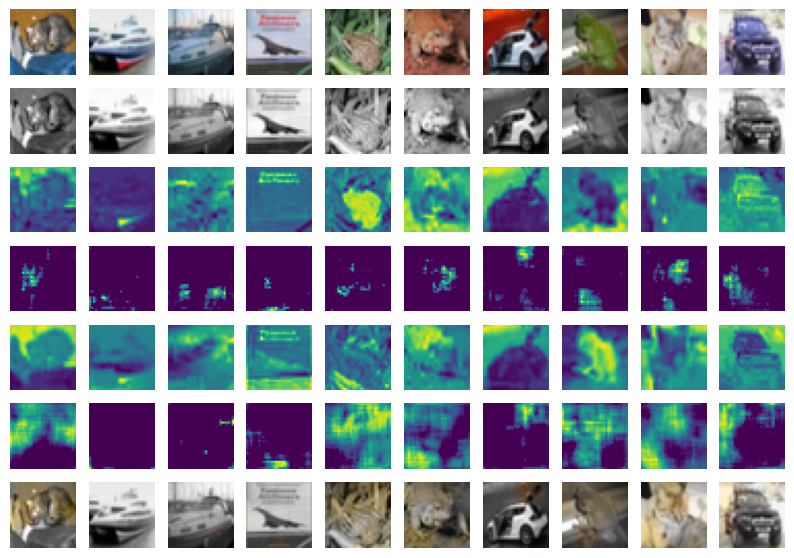


Test Loss: 0.017391487956047058
Test Accuracy: tensor(0.1000) 



In [16]:
#model testing with whole test data
model = get_model(exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config["device"])))
print("\n\nTesting Saved Model")
mt = ModelTester(model, te_dataset)
mt.test_and_plot(ds["RGBte"], ABte, "best_model", True)